In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, LeaveOneOut
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from IPython.display import display

In [ ]:
# Carregar base
df = pd.read_csv("fermentacao_etanol.csv")

In [ ]:
# Limpar base
df_limpa = df.dropna(subset=["Tempo (h)", "Temperatura (°C)", "pH", "Glicose (g/L)", "Agitação (rpm)", "Rendimento Etanol (%)"])
df_limpa = df_limpa[
    (df_limpa["pH"].between(3.5, 6.0)) &
    (df_limpa["Glicose (g/L)"] <= 300) &
    (df_limpa["Tempo (h)"].between(12, 48))
]

In [ ]:
# Criar variável binária de eficiência
df_poly = df_limpa.copy()
df_poly["Eficiente"] = (df_poly["Rendimento Etanol (%)"] >= 50).astype(int)

In [ ]:
# Selecionar preditores e resposta
X = df_poly[["Temperatura (°C)", "Tempo (h)", "pH", "Glicose (g/L)", "Agitação (rpm)"]]
y = df_poly["Eficiente"]

In [ ]:
# Validação cruzada k-fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
modelo_lr = LogisticRegression(max_iter=1000)
scores_kfold = cross_val_score(modelo_lr, X, y, cv=kfold, scoring="accuracy")
display(scores_kfold)
display(scores_kfold.mean())

array([0.87022901, 0.87643312, 0.87133758, 0.88407643, 0.89681529])

np.float64(0.8797782856031506)

In [ ]:
# Validação leave-one-out
loo = LeaveOneOut()
scores_loo = cross_val_score(modelo_lr, X, y, cv=loo, scoring="accuracy")
display(scores_loo)
display(scores_loo.mean())

array([1., 1., 1., ..., 1., 0., 1.])

np.float64(0.8807947019867549)

In [ ]:
# Resultados da reamostragem
resultados_reamostragem = pd.DataFrame({
    "Método": ["K-Fold (5)", "Leave-One-Out"],
    "Acurácia Média": [scores_kfold.mean(), scores_loo.mean()]
})
print("Validação Cruzada - Reamostragem")
display(resultados_reamostragem)

Validação Cruzada - Reamostragem


,Método,Acurácia Média
0,K-Fold (5),0.879778
1,Leave-One-Out,0.880795


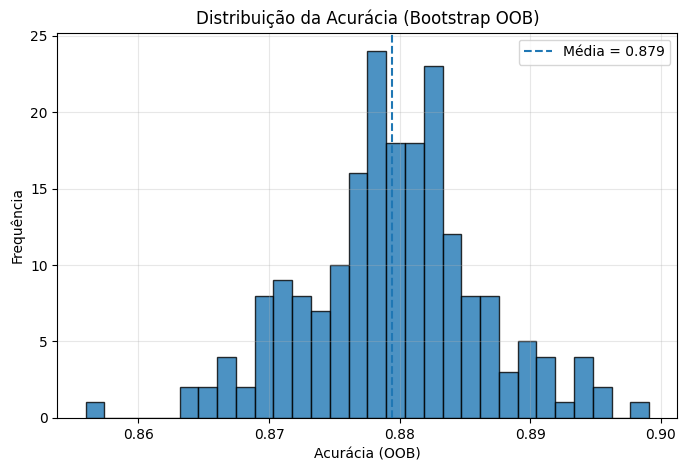

Acurácia OOB - média: 0.8794
Acurácia OOB - desvio-padrão: 0.0067


In [ ]:
idx_all = np.arange(len(X))
acc_boot_oob = []
n_bootstraps = 200

for i in range(n_bootstraps):
    # Amostra bootstrap por índices (para conseguir identificar OOB)
    boot_idx = resample(idx_all, replace=True, random_state=i)
    oob_idx = np.setdiff1d(idx_all, boot_idx)

    # Se por acaso não sobrar OOB (raro em bases pequenas), pula a iteração
    if oob_idx.size == 0:
        continue

    # Treina o mesmo modelo logístico usado no K-Fold/LOOCV
    modelo_lr.fit(X.iloc[boot_idx], y.iloc[boot_idx])

    # Acurácia medida nos exemplos fora da amostra (OOB)
    y_pred_oob = modelo_lr.predict(X.iloc[oob_idx])
    acc_oob = accuracy_score(y.iloc[oob_idx], y_pred_oob)
    acc_boot_oob.append(acc_oob)

# Gráfico da distribuição das acurácias OOB no bootstrap
plt.figure(figsize=(8,5))
plt.hist(acc_boot_oob, bins=30, edgecolor='black', alpha=0.8)
plt.axvline(np.mean(acc_boot_oob), linestyle='--', label=f'Média = {np.mean(acc_boot_oob):.3f}')
plt.title('Distribuição da Acurácia (Bootstrap OOB)')
plt.xlabel('Acurácia (OOB)')
plt.ylabel('Frequência')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Resumo numérico simples (opcional)
print(f'Acurácia OOB - média: {np.mean(acc_boot_oob):.4f}')
print(f'Acurácia OOB - desvio-padrão: {np.std(acc_boot_oob):.4f}')

In [ ]:
# Bootstrap para erro padrão dos coeficientes
coefs_bootstrap = []

for i in range(n_bootstraps):
    X_resample, y_resample = resample(X, y, replace=True, random_state=i)
    X_resample_const = sm.add_constant(X_resample)
    model = sm.Logit(y_resample, X_resample_const).fit(disp=0)
    coefs_bootstrap.append(model.params.values)

coefs_bootstrap = np.array(coefs_bootstrap)
coef_std_bootstrap = np.std(coefs_bootstrap, axis=0)
# Nomear os coeficientes
coef_names = ["const"] + X.columns.tolist()
bootstrap_result = pd.DataFrame({
    "Coeficiente": coef_names,
    "Erro Padrão (Bootstrap)": coef_std_bootstrap
})
print(" Erro Padrão via Bootstrap")
display(bootstrap_result)

 Erro Padrão via Bootstrap


,Coeficiente,Erro Padrão (Bootstrap)
0,const,0.931468
1,Temperatura (°C),0.013169
2,Tempo (h),0.010105
3,pH,0.102571
4,Glicose (g/L),0.001955
5,Agitação (rpm),0.000892


1 reamostragens → erro médio = 0.0000
2 reamostragens → erro médio = 0.0520
3 reamostragens → erro médio = 0.1006
4 reamostragens → erro médio = 0.1113
5 reamostragens → erro médio = 0.1407
6 reamostragens → erro médio = 0.1305
7 reamostragens → erro médio = 0.1384
8 reamostragens → erro médio = 0.1300
9 reamostragens → erro médio = 0.1745
10 reamostragens → erro médio = 0.1665
11 reamostragens → erro médio = 0.1600
12 reamostragens → erro médio = 0.1555
13 reamostragens → erro médio = 0.1537
14 reamostragens → erro médio = 0.1520
15 reamostragens → erro médio = 0.1531
16 reamostragens → erro médio = 0.1531
17 reamostragens → erro médio = 0.1606
18 reamostragens → erro médio = 0.1595
19 reamostragens → erro médio = 0.1630
20 reamostragens → erro médio = 0.1611
30 reamostragens → erro médio = 0.1851
40 reamostragens → erro médio = 0.1849
50 reamostragens → erro médio = 0.1911
60 reamostragens → erro médio = 0.1846
70 reamostragens → erro médio = 0.1842
80 reamostragens → erro médio = 0.

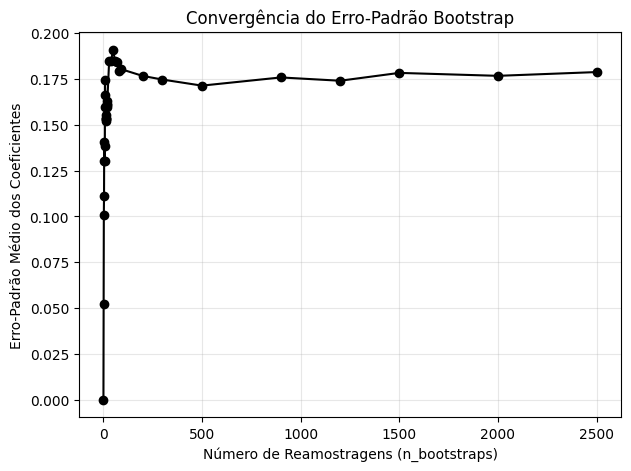

In [ ]:
# Lista de tamanhos de amostras Bootstrap a testar
n_list = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50, 60, 70, 80, 90, 200, 300, 500, 900, 1200, 1500, 2000, 2500]
erro_medio = []

for n_boot in n_list:
    coefs = []
    for i in range(n_boot):
        X_r, y_r = resample(X, y, replace=True, random_state=i)
        X_r_const = sm.add_constant(X_r)
        model = sm.Logit(y_r, X_r_const).fit(disp=0)
        coefs.append(model.params.values)

    coefs = np.array(coefs)
    # Média dos erros-padrão (variação média dos coeficientes)
    erro_medio.append(coefs.std(axis=0).mean())
    print(f"{n_boot} reamostragens → erro médio = {erro_medio[-1]:.4f}")

# Plot
plt.figure(figsize=(7,5))
plt.plot(n_list, erro_medio, marker='o', color='black')
plt.title("Convergência do Erro-Padrão Bootstrap")
plt.xlabel("Número de Reamostragens (n_bootstraps)")
plt.ylabel("Erro-Padrão Médio dos Coeficientes")
plt.grid(True, alpha=0.3)
plt.show()